In [37]:
# =====================================
# AI Data Center Policy Model
# Deterministic Baseline Replication
# =====================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
plt.rcParams["figure.dpi"] = 140



In [38]:
import sys
from pathlib import Path

# Add project root to path so we can import from src/
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.model import build_policy_table


In [39]:
# =====================================
# Unit Conversions
# =====================================

TWH_TO_KWH = 1e9          # 1 TWh = 1e9 kWh
GRAMS_TO_METRIC_TON = 1e-6
METRIC_TON_TO_MMT = 1e-6


def emissions_mmt(y_twh: float, c_g_per_kwh: float) -> float:
    """
    Computes emissions in million metric tons (MMT CO2)

    E = Y * C
    Y in TWh
    C in gCO2/kWh
    """
    grams = y_twh * TWH_TO_KWH * c_g_per_kwh
    metric_tons = grams * GRAMS_TO_METRIC_TON
    mmt = metric_tons * METRIC_TON_TO_MMT
    return mmt


In [40]:
# =====================================
# 2028 Baseline and Policy Inputs
# (From Econ 199 Paper)
# =====================================

policy_inputs = [
    {"Policy": "Baseline",
     "Y_TWh": 448,
     "C_g_per_kWh": 570,
     "Gov_Impact_$B": 0.00,
     "Firm_Impact_$B": 0.00},

    {"Policy": "Carbon Tax ($30/ton)",
     "Y_TWh": 403,
     "C_g_per_kWh": 513,
     "Gov_Impact_$B": 6.63,
     "Firm_Impact_$B": -7.66},

    {"Policy": "Clean Energy Subsidy",
     "Y_TWh": 480,
     "C_g_per_kWh": 412,
     "Gov_Impact_$B": -2.25,
     "Firm_Impact_$B": -2.83},

    {"Policy": "Dynamic Energy Pricing",
     "Y_TWh": 490,
     "C_g_per_kWh": 426,
     "Gov_Impact_$B": -0.07,   # $70M admin
     "Firm_Impact_$B": -4.65},

    {"Policy": "Clean Energy Mandate (50%)",
     "Y_TWh": 480,
     "C_g_per_kWh": 500,
     "Gov_Impact_$B": -0.05,   # small compliance/admin
     "Firm_Impact_$B": -2.24},
]

df = pd.DataFrame(policy_inputs)

df


,Policy,Y_TWh,C_g_per_kWh,Gov_Impact_$B,Firm_Impact_$B
0,Baseline,448,570,0.000,0.000
1,Carbon Tax ($30/ton),403,513,6.630,-7.660
2,Clean Energy Subsidy,480,412,-2.250,-2.830
3,Dynamic Energy Pricing,490,426,-0.070,-4.650
4,Clean Energy Mandate (50%),480,500,-0.050,-2.240


In [41]:
df = build_policy_table(policy_inputs)
df


,Policy,Y_TWh,C_g_per_kWh,Gov_Impact_$B,Firm_Impact_$B,Emissions_MMT,Abatement_MMT,Abatement_%
0,Baseline,448,570,0.000,0.000,255.360,0.000,0.000
1,Carbon Tax ($30/ton),403,513,6.630,-7.660,206.739,48.621,19.040
2,Clean Energy Subsidy,480,412,-2.250,-2.830,197.760,57.600,22.556
3,Dynamic Energy Pricing,490,426,-0.070,-4.650,208.740,46.620,18.257
4,Clean Energy Mandate (50%),480,500,-0.050,-2.240,240.000,15.360,6.015


## Replication Check

This section verifies that Python results exactly match the emissions and abatement values reported in the Econ 199 paper.


In [42]:
replication_check = df[[
    "Policy",
    "Emissions_MMT",
    "Abatement_MMT",
    "Abatement_%"
]].copy()

replication_check.round(3)


,Policy,Emissions_MMT,Abatement_MMT,Abatement_%
0,Baseline,255.360,0.000,0.000
1,Carbon Tax ($30/ton),206.739,48.621,19.040
2,Clean Energy Subsidy,197.760,57.600,22.556
3,Dynamic Energy Pricing,208.740,46.620,18.257
4,Clean Energy Mandate (50%),240.000,15.360,6.015


In [43]:
from src.metrics import add_cost_per_ton_metrics


In [44]:
df = add_cost_per_ton_metrics(df)

efficiency_table = df[[
    "Policy",
    "Abatement_MMT",
    "Gov_$per_ton",
    "Firm_$per_ton",
    "Total_$per_ton"
]].round(2)

efficiency_table


,Policy,Abatement_MMT,Gov_$per_ton,Firm_$per_ton,Total_$per_ton
0,Baseline,0.000,NaN,NaN,NaN
1,Carbon Tax ($30/ton),48.620,136.360,-157.550,-21.180
2,Clean Energy Subsidy,57.600,-39.060,-49.130,-88.190
3,Dynamic Energy Pricing,46.620,-1.500,-99.740,-101.240
4,Clean Energy Mandate (50%),15.360,-3.260,-145.830,-149.090


In [45]:
ranked = efficiency_table.copy()

# Drop baseline (it has 0 abatement -> cost/ton is undefined)
ranked = ranked[ranked["Policy"] != "Baseline"].copy()

ranked["Rank (Best=1)"] = ranked["Total_$per_ton"].rank(method="min").astype(int)
ranked = ranked.sort_values("Rank (Best=1)")

ranked


,Policy,Abatement_MMT,Gov_$per_ton,Firm_$per_ton,Total_$per_ton,Rank (Best=1)
4,Clean Energy Mandate (50%),15.360,-3.260,-145.830,-149.090,1
3,Dynamic Energy Pricing,46.620,-1.500,-99.740,-101.240,2
2,Clean Energy Subsidy,57.600,-39.060,-49.130,-88.190,3
1,Carbon Tax ($30/ton),48.620,136.360,-157.550,-21.180,4


In [46]:
ranked_view = ranked[[
    "Policy",
    "Abatement_MMT",
    "Gov_$per_ton",
    "Firm_$per_ton",
    "Total_$per_ton",
    "Rank (Best=1)"
]].copy()

ranked_view = ranked_view.round({
    "Abatement_MMT": 3,
    "Gov_$per_ton": 2,
    "Firm_$per_ton": 2,
    "Total_$per_ton": 2
})

ranked_view


,Policy,Abatement_MMT,Gov_$per_ton,Firm_$per_ton,Total_$per_ton,Rank (Best=1)
4,Clean Energy Mandate (50%),15.360,-3.260,-145.830,-149.090,1
3,Dynamic Energy Pricing,46.620,-1.500,-99.740,-101.240,2
2,Clean Energy Subsidy,57.600,-39.060,-49.130,-88.190,3
1,Carbon Tax ($30/ton),48.620,136.360,-157.550,-21.180,4


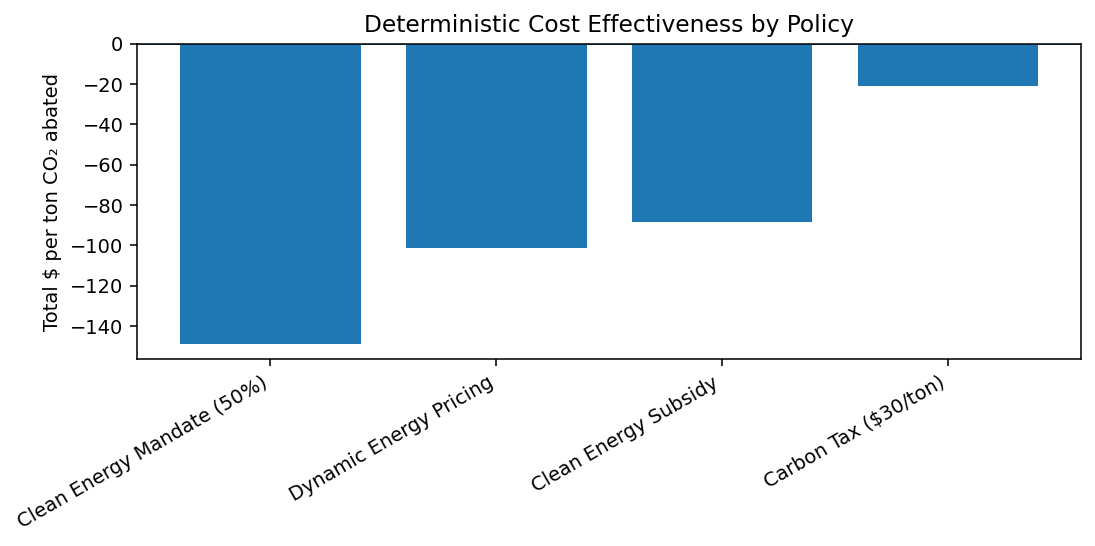

In [47]:
plot_df = ranked.sort_values("Total_$per_ton").copy()

plt.figure(figsize=(8,4))
plt.bar(plot_df["Policy"], plot_df["Total_$per_ton"])
plt.axhline(0, linewidth=1)
plt.ylabel("Total $ per ton CO₂ abated")
plt.xticks(rotation=30, ha="right")
plt.title("Deterministic Cost Effectiveness by Policy")
plt.tight_layout()
plt.show()


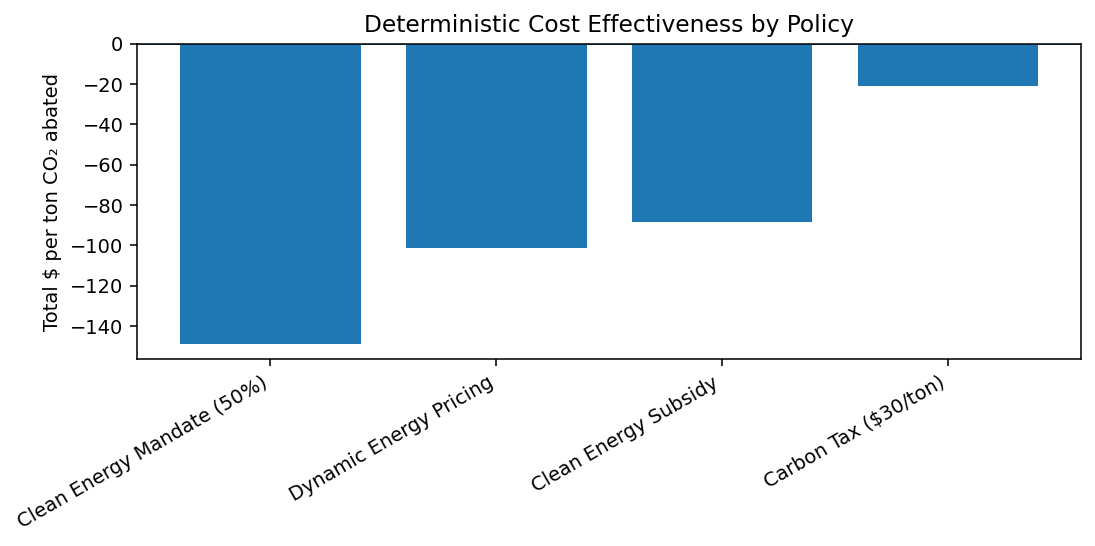

In [48]:
from pathlib import Path

OUT_TABLES = PROJECT_ROOT / "outputs" / "tables"
OUT_FIGS = PROJECT_ROOT / "outputs" / "figures"
OUT_TABLES.mkdir(parents=True, exist_ok=True)
OUT_FIGS.mkdir(parents=True, exist_ok=True)

# Save tables
replication_check.to_csv(OUT_TABLES / "replication_check.csv", index=False)
ranked_view.to_csv(OUT_TABLES / "deterministic_ranked_cost_per_ton.csv", index=False)

# Save figure
plt.figure(figsize=(8,4))
plt.bar(plot_df["Policy"], plot_df["Total_$per_ton"])
plt.axhline(0, linewidth=1)
plt.ylabel("Total $ per ton CO₂ abated")
plt.xticks(rotation=30, ha="right")
plt.title("Deterministic Cost Effectiveness by Policy")
plt.tight_layout()
plt.savefig(OUT_FIGS / "deterministic_cost_effectiveness.png")
plt.show()
